In [1]:
#plot auroc
# Function used to import and rename columns from the external prediction text files:
import numpy as np
dict_pred = {'NAMP': 0, 'AMP':1}

def import_and_rename(file, method):
    df = pd.read_csv(file, sep='\s+', header=None)
    
    if method == 'ANN':
        df = df.rename(columns={0: "id_ref", 1: "AMP_Pred", 2: "Probability"})
    else:
        df = df.rename(columns={0: "id_ref", 1: "AMP_Pred", 2: "Probability"})
    
    # Mapping dictionary of boolean value to Prediction column:
    df['AMP_Pred'] = df['AMP_Pred'].map(dict_pred)
    
    return df
import pandas as pd
camp_ANN = import_and_rename('../Predictions/INDEP/CAMP/CAMP_ANN.txt', 'ANN')
camp_DA = import_and_rename('../Predictions/INDEP/CAMP/CAMP_DA.txt', 'DA')
camp_RF = import_and_rename('../Predictions/INDEP/CAMP/CAMP_RF.txt', 'RF')
camp_SVM = import_and_rename('../Predictions/INDEP/CAMP/CAMP_SVM.txt', 'SVM')
# camp_ANN.head()
camp_ANN_label = np.array(camp_ANN['Probability'])
camp_DA_label = np.array(camp_DA['Probability'])
camp_RF_label = np.array(camp_RF['Probability'])
camp_SVM_label = np.array(camp_SVM['Probability'])

#AmPEP
AmPEP = pd.read_csv("../Predictions/INDEP/AmPEP_results.csv")
AmPEP.head()
AmPEP_label = np.array(AmPEP['probability_AMP'])

#Veltri
veltriPred = pd.read_csv("../Predictions/INDEP/veltri.csv")
dict_pred_velt = {'Non-AMP': 0, 'AMP':1}
veltriPred['Prediction_Class'] = veltriPred['Prediction_Class'].map(dict_pred_velt)
veltriPred.head()
veltriPred_label = np.array(veltriPred['Prediction_Probability'])

#LMPred
LMPred_BERT =  np.load('../Predictions/INDEP/INDEP_BERT_Model_Preds.npy')
LMPred_BERT_BFD =  np.load('../Predictions/INDEP/INDEP_BERT_BFD_Model_Preds.npy')
LMPred_T5XL_UNI =  np.load('../Predictions/INDEP/INDEP_T5XL_UNI_Model_Preds.npy')
LMPred_T5XL_BFD =  np.load('../Predictions/INDEP/INDEP_T5XL_BFD_Model_Preds.npy')
LMPred_XLNET =  np.load('../Predictions/INDEP/INDEP_XLNET_Model_Preds.npy')
LMPred_BERT[:5]

#real
real = pd.read_csv('../dataset/plant_test.csv')
real_label = np.array(real.Label)
real.head()

#PTCLPAMP
PTCLPAMP_label = np.load('../Predictions/INDEP/INDEP_PTCLPAMP_lam1.0_Preds.npy').reshape(-1)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm

plt.rcParams['font.sans-serif'] = ['SimSun']
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 示例数据
# y_true = np.array([...])  # 真实标签
y_true = real_label

y_scores_dict = {
    'CAMP-ANN': camp_ANN_label,  # 模型1的预测概率
    'CAMP-DA': camp_DA_label,    # 模型2的预测概率
    'CAMP-RF': camp_RF_label,    # 模型3的预测概率
    'CAMP-SVM': camp_SVM_label,
    'AmPEP': AmPEP_label,
    'Veltri-DNN': veltriPred_label,
    'LMPred-BERT': LMPred_BERT,
    'LMPred-BERT-BFD': LMPred_BERT_BFD,
    'LMPred-T5XL-UNI': LMPred_T5XL_UNI,
    'LMPred-T5XL-BFD': LMPred_T5XL_BFD,
    'LMPred-XLNET': LMPred_XLNET,
    'PCLPAMP': PTCLPAMP_label,
    # 添加更多模型预测结果
}

def plot_roc_curves(y_true, y_scores_dict):
    plt.figure(figsize=(6, 6.5))
    colors = cm.Greys(np.linspace(0.8, 0.8, len(y_scores_dict)))  # 为每个模型生成不同颜色，从浅灰到深黑
    markers = ['o', 's', '^', 'p', 'D', 'v', '<', '>', '*', 'x', 'd', '+']  # 不同形状的标记
    markevery = 60  # 每隔20个点使用一个标记
    markersize = 6  # 设置标记大小
    linewidth = 1  # 设置曲线宽度

    sorted_y_scores_dict = dict(sorted(y_scores_dict.items(), key=lambda item: auc(roc_curve(y_true, item[1])[0], roc_curve(y_true, item[1])[1]), reverse=True))  # 根据 AUROC 排序

    for i, (model_name, y_scores) in enumerate(sorted_y_scores_dict.items()):
        color = colors[i]
        marker = markers[i]
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=linewidth, color=color, marker=marker, markersize=markersize, markevery=markevery, label=f'{model_name} (AUROC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=0.8)  # 对角线颜色为黑色
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假阳性率', fontsize=7.5)
    plt.ylabel('真阳性率', fontsize=7.5)
    plt.title('ROC 曲线', fontsize=7.5)
    plt.legend(loc="lower right", fontsize=7.5)
    plt.grid(alpha=0.3)
    plt.xticks(fontsize=7.5)
    plt.yticks(fontsize=7.5)
    plt.savefig('../Figures/INDEP/gray/ROC_Curves_Gray.svg', bbox_inches='tight', dpi=300)
    plt.show()

# 绘制ROC曲线
plot_roc_curves(y_true, y_scores_dict)


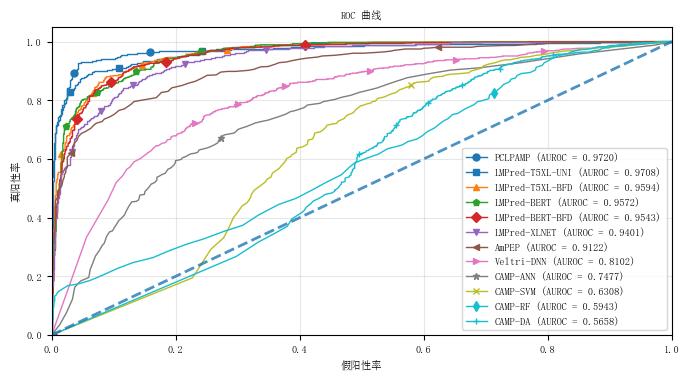

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm

plt.rcParams['font.sans-serif'] = ['SimSun']
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 示例数据
# y_true = np.array([...])  # 真实标签
y_true = real_label

y_scores_dict = {
    'CAMP-ANN': camp_ANN_label,  # 模型1的预测概率
    'CAMP-DA': camp_DA_label,    # 模型2的预测概率
    'CAMP-RF': camp_RF_label,    # 模型3的预测概率
    'CAMP-SVM': camp_SVM_label,
    'AmPEP': AmPEP_label,
    'Veltri-DNN': veltriPred_label,
    'LMPred-BERT': LMPred_BERT,
    'LMPred-BERT-BFD': LMPred_BERT_BFD,
    'LMPred-T5XL-UNI': LMPred_T5XL_UNI,
    'LMPred-T5XL-BFD': LMPred_T5XL_BFD,
    'LMPred-XLNET': LMPred_XLNET,
    'PCLPAMP': PTCLPAMP_label,
    # 添加更多模型预测结果
}

def plot_roc_curves(y_true, y_scores_dict):
    plt.figure(figsize=(8, 4))
    colors = cm.tab10(np.linspace(0, 1, len(y_scores_dict)))  # 为每个模型生成不同颜色，从调色板中选取
    markers = ['o', 's', '^', 'p', 'D', 'v', '<', '>', '*', 'x', 'd', '+']  # 不同形状的标记
    markevery = 60  # 每隔60个点使用一个标记
    markersize = 5  # 设置标记大小
    linewidth = 1  # 设置曲线宽度

    sorted_y_scores_dict = dict(sorted(y_scores_dict.items(), key=lambda item: auc(roc_curve(y_true, item[1])[0], roc_curve(y_true, item[1])[1]), reverse=True))  # 根据 AUROC 排序

    for i, (model_name, y_scores) in enumerate(sorted_y_scores_dict.items()):
        color = colors[i]
        marker = markers[i % len(markers)]  # 防止marker不足时索引越界
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=linewidth, color=color, marker=marker, markersize=markersize, markevery=markevery, label=f'{model_name} (AUROC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, alpha=0.8)  # 对角线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假阳性率', fontsize=7.5)
    plt.ylabel('真阳性率', fontsize=7.5)
    plt.title('ROC 曲线', fontsize=7.5)
    plt.legend(loc="lower right", fontsize=7.5)
    plt.grid(alpha=0.3)
    plt.xticks(fontsize=7.5)
    plt.yticks(fontsize=7.5)
    plt.savefig('../Figures/INDEP/color/ROC_Curves_Color.svg', bbox_inches='tight', dpi=300)
    plt.show()

# 绘制ROC曲线
plot_roc_curves(y_true, y_scores_dict)
